In [1]:
from pynq import Overlay, allocate
ol = Overlay("/home/xilinx/jupyter_notebooks/hakaton/accelerator.bit")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import time
from IPython.display import display
from PIL import Image

In [3]:
dma0 = ol.axi_dma_0
dma1 = ol.axi_dma_1

In [4]:
IP_BASE_ADDRESS = ol.ip_dict['example_design_0']['phys_addr'] #can be hard-coded to 0x60000000
ADDRESS_RANGE = ol.ip_dict['example_design_0']['addr_range'] #can be hard-coded to 0x1000

## print(hex(IP_BASE_ADDRESS))
## print(hex(ADDRESS_RANGE))

from pynq import MMIO
mmio = MMIO(IP_BASE_ADDRESS, ADDRESS_RANGE)

In [20]:
## mmio.write(4,12) # write 42 @ address offset 4

#check reset values are visible in memory-mapped registers
result1 = mmio.read(0) # read at offset 0
result2 = mmio.read(4) # read at offset 4
result3 = mmio.read(8) # ...
result4 = mmio.read(12)
print(result1)
print(result2)
print(result3)
print(result4)


1
1
524288
0


In [6]:
def rgb2gray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

#Load input image from located path and convert it to grayscale
def load_image(filepath):
  img = plt.imread(filepath)
  if (img.dtype == float) and (max(img.flatten())<=1):
      img = rgb2gray(img)
      img = np.clip(img, 0, 1) * 255
  else:
      img = rgb2gray(img)
  img = img.astype(np.uint8)
  return img

In [7]:
image = load_image('/home/xilinx/jupyter_notebooks/hakaton/lena_gray.gif')
for i in range(20):
  print (hex(image[i,1]))

0xa1
0xa1
0xa1
0xa1
0xa1
0xa3
0x9f
0x9e
0x9a
0x9a
0x9b
0x9b
0x9d
0x9c
0x9d
0x9d
0x9b
0x9c
0x9c
0x99


In [8]:
input_buffer   = allocate(shape=image.shape, dtype=np.uint8)
output_buffer1 = allocate(shape=image.shape, dtype=np.uint8)
output_buffer2 = allocate(shape=image.shape, dtype=np.uint16)

In [9]:
input_buffer[:] = image

In [16]:
t1 = time.perf_counter()

In [17]:
dma0.sendchannel.transfer(input_buffer)
dma0.recvchannel.transfer(output_buffer1)
dma1.recvchannel.transfer(output_buffer2)

dma0.sendchannel.wait()
dma0.recvchannel.wait()
dma1.recvchannel.wait()

In [18]:
t2 = time.perf_counter()
print("Time from starting DMA Tx to completing DMA Rx is "+str(t2-t1)+" seconds")

Time from starting DMA Tx to completing DMA Rx is 0.8608745960000306 seconds


In [11]:
for i in range(20):
  print (hex(output_buffer1[i,1]))

0x50
0x50
0x50
0x50
0x50
0x51
0x4f
0x4f
0x4d
0x4d
0x4d
0x4d
0x4e
0x4e
0x4e
0x4e
0x4d
0x4e
0x4e
0x4c


In [12]:
for i in range(20):
  print (hex(output_buffer2[i,1]))

0x4242
0x4242
0x4242
0x4242
0x4242
0x4646
0x3e3e
0x3c3c
0x3434
0x3434
0x3636
0x3636
0x3a3a
0x3838
0x3a3a
0x3a3a
0x3636
0x3838
0x3838
0x3232


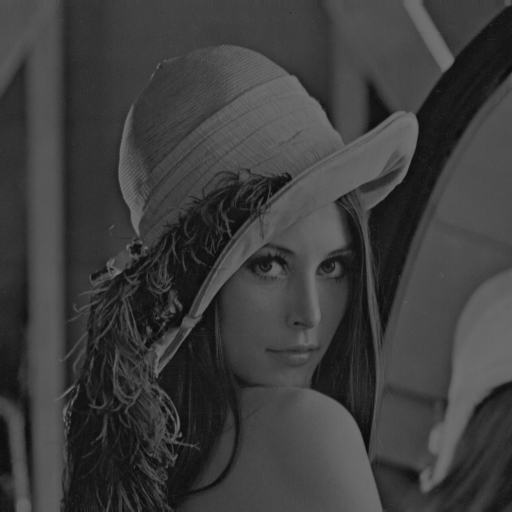

In [13]:
display(Image.fromarray(output_buffer1))

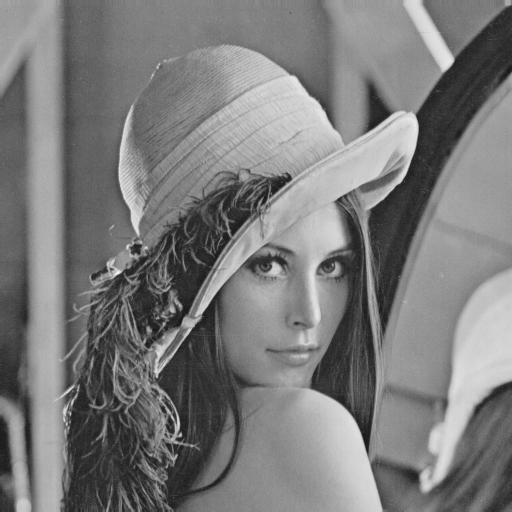

In [14]:
display(Image.fromarray(input_buffer))

In [15]:
mmio.write(4,1)